In [75]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/Homework


In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path
import cv2

In [77]:
path = Path().absolute() / "dataset" / "training_set.npz"

with np.load(path) as data:
  samples = data['images']
  labels = data['labels']

label_values = [
  "Basophil", "Eosinophil", "Erythroblast",
  "Immature granulocytes", "Lymphocyte", "Monocyte",
  "Neutrophil", "Platelet"]


In [244]:
hue_min_deg, hue_max_deg = 180, 360
sat_min_perc, sat_max_perc = 22, 100
val_min_perc, val_max_perc = 20, 70

hue_min = int(hue_min_deg / 2)
hue_max = int(hue_max_deg / 2)
sat_min = int(sat_min_perc * 255 / 100)
sat_max = int(sat_max_perc * 255 / 100)
val_min = int(val_min_perc * 255 / 100)
val_max = int(val_max_perc * 255 / 100)

hue_filtered_images = []

bb_images = []

filtered_images = []

for sample in samples:
  hsv_img = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)
  mask = cv2.inRange(hsv_img, (hue_min, sat_min, val_min), (hue_max, sat_max, val_max))
  masked_img = cv2.bitwise_and(sample, sample, mask=mask)


  gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

  _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)


  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))  # Adjust size to connect sparse pixels
  dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)

  contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    convex_hull = cv2.convexHull(largest_contour)
  else:
    convex_hull = None

  mask = np.zeros_like(dilated_mask)
  if convex_hull is not None:
    cv2.drawContours(mask, [convex_hull], -1, (255), thickness=cv2.FILLED)

  bb_image = cv2.bitwise_and(sample, sample, mask=mask)

  black_mask = np.all(bb_image == [0, 0, 0], axis=-1)
  no_bg_img = bb_image.copy()
  no_bg_img[black_mask] = [247, 222, 197] #yellowish

  hue_filtered_images.append(masked_img)
  bb_images.append(bb_image)
  filtered_images.append(no_bg_img)


In [246]:
filtered_images_indexes = random.sample(range(len(filtered_images)), 10)

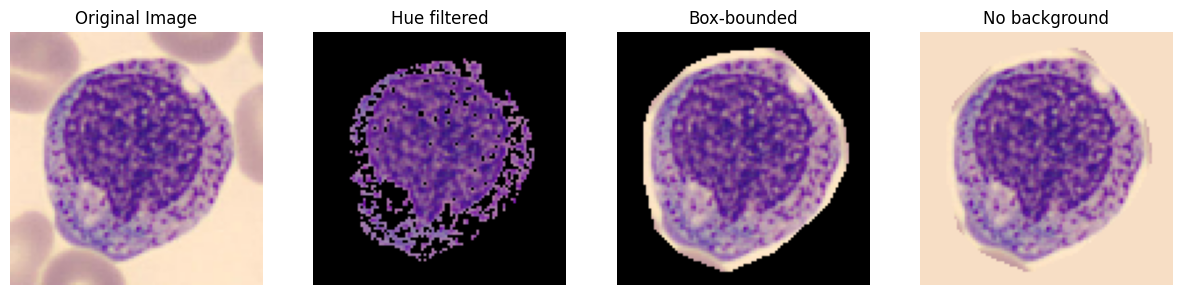

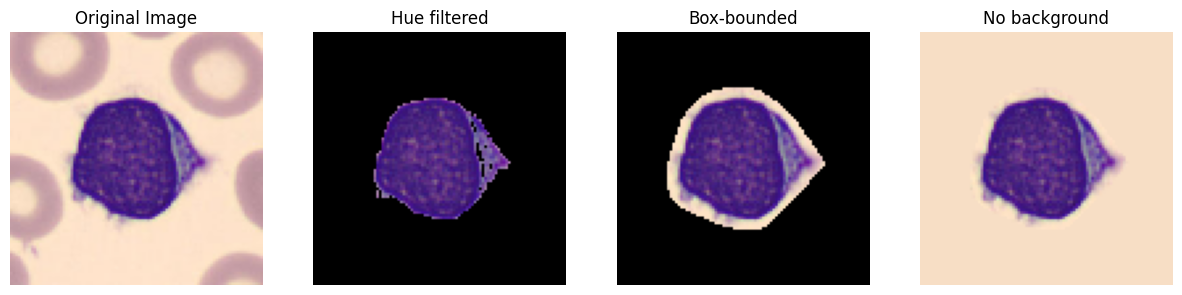

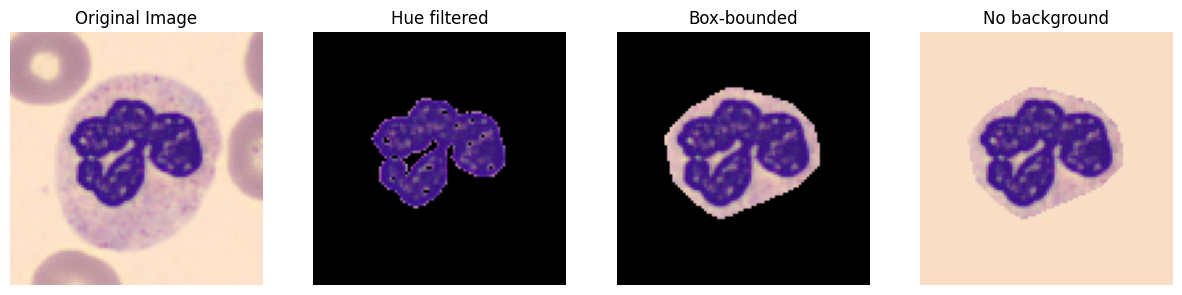

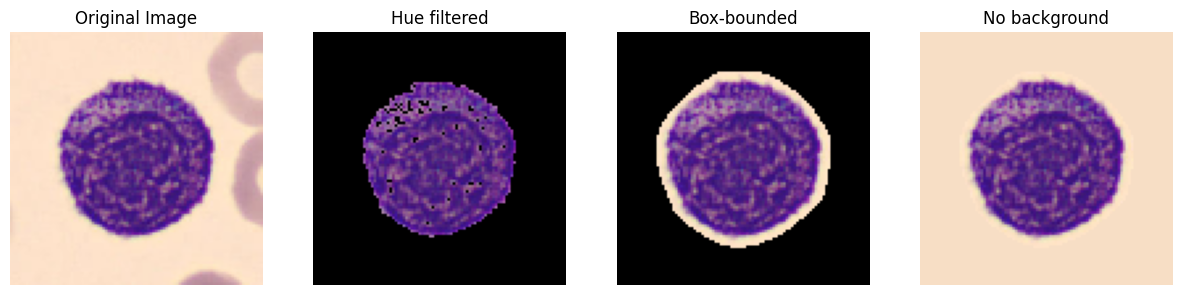

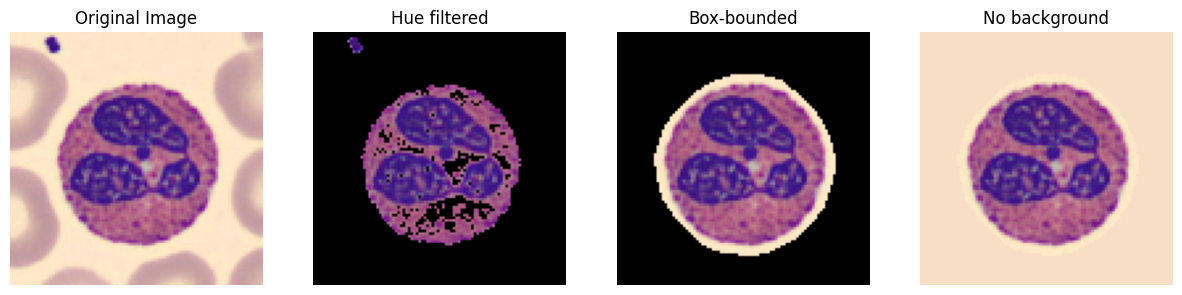

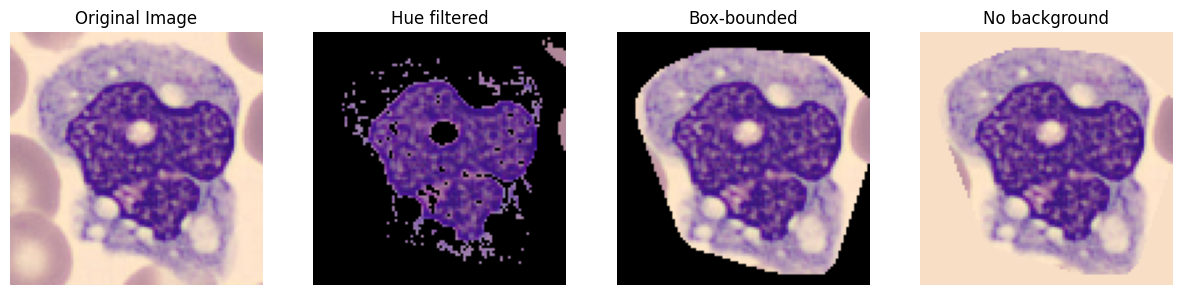

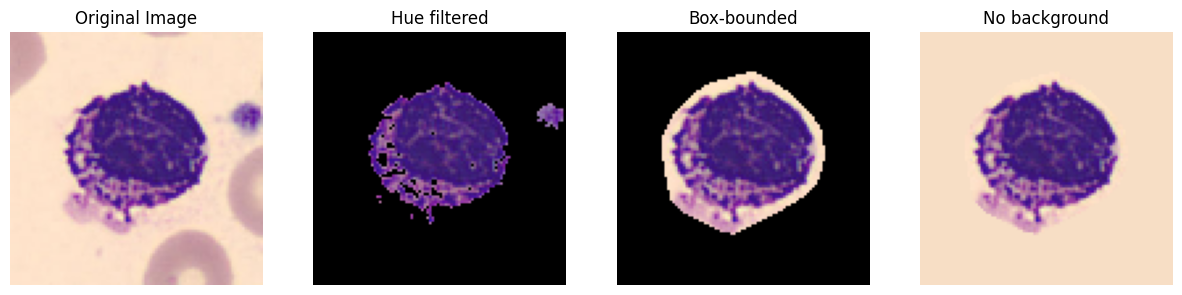

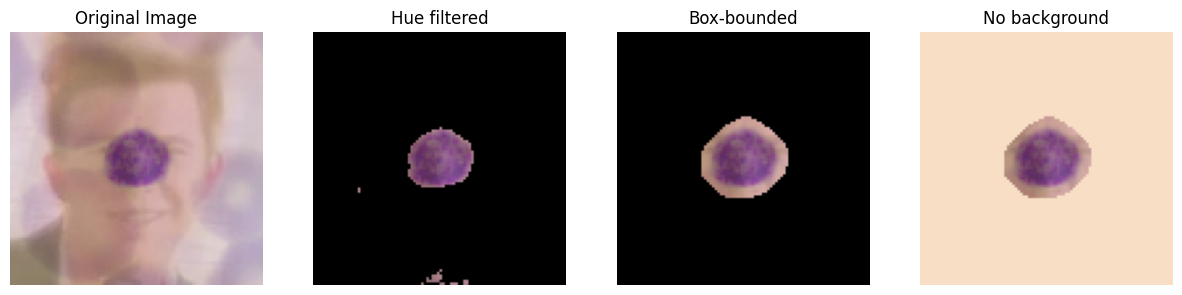

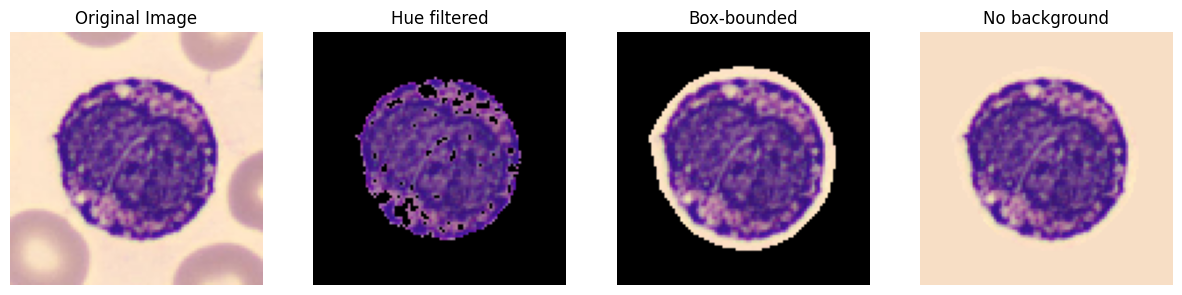

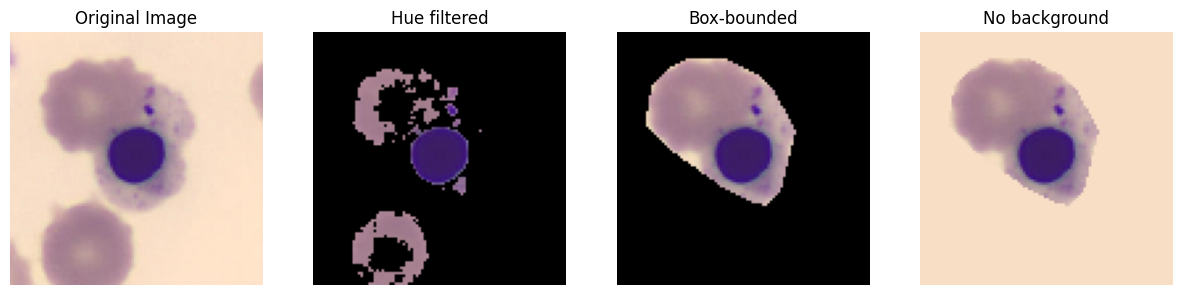

In [247]:
import matplotlib.pyplot as plt



for i in filtered_images_indexes:
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(samples[i])
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 4, 2)
  plt.imshow(hue_filtered_images[i])
  plt.title("Hue filtered")
  plt.axis("off")

  plt.subplot(1, 4, 3)
  plt.imshow(bb_images[i])
  plt.title("Box-bounded")
  plt.axis("off")

  plt.subplot(1, 4, 4)
  plt.imshow(filtered_images[i])
  plt.title("No background")
  plt.axis("off")

  plt.show()



In [166]:
for sample in filtered_images:
  gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

  _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours of non-black regions
  contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a convex hull around the largest contour
  if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    convex_hull = cv2.convexHull(largest_contour)
  else:
    convex_hull = None

# Create a mask based on the convex hull
  mask = np.zeros_like(binary_mask)
  if convex_hull is not None:
    cv2.drawContours(mask, [convex_hull], -1, (255), thickness=cv2.FILLED)